This Notebook is for my Coursera Capstone Project. I'll be using Catalonia collisions data from Kaggle ([link](https://www.kaggle.com/jordigarciacastillon/road-traffic-injuries-deaths-catalonia-201020)).

In [119]:
import pandas as pd
import numpy as np
%matplotlib inline 
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
import datetime
import itertools
from matplotlib.ticker import NullFormatter
import matplotlib.ticker as ticker
from sklearn import metrics
from sklearn.metrics import jaccard_score
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss

Let's download and get familiar with the database.

In [30]:
df=pd.read_csv(r"C:\Users\Iana\Dropbox\acc_catalonia_data.csv")

In [31]:
df.shape

(16774, 58)

In [32]:
df.head(3)

,Any,zona,dat,via,pk,nomMun,nomCom,nomDem,F_MORTS,F_FERITS_GREUS,...,D_SUPERFICIE,D_TIPUS_VIA,D_TITULARITAT_VIA,D_TRACAT_ALTIMETRIC,D_VENT,grupDiaLab,hor,grupHor,tipAcc,tipDia
0,2010,Zona urbana,25/01/2010,SE,999999.0,CANOVES I SAMALUS,Valles Oriental,Barcelona,0,1,...,Sec i net,Via urbana( inclou carrer i carrer residencial),NaN,NaN,"Calma, vent molt suau",Feiners,2333,Nit,Col.lisió de vehicles en marxa,dill-dij
1,2010,Carretera,31/10/2010,N-240,999.0,LLEIDA,Segria,Lleida,0,1,...,Sec i net,Carretera convencional,Estatal,Pla,"Calma, vent molt suau",CapDeSetmana,1,Nit,Sortida de la calcada sense especificar,dg
2,2010,Carretera,17/05/2010,N-II,7087.0,FORNELLS DE LA SELVA,Girones,Girona,1,0,...,Sec i net,Carretera convencional,Estatal,Rampa o pendent,"Calma, vent molt suau",Feiners,1527,Tarda,Col.lisió de vehicles en marxa,dill-dij


It'd be better if we translate columns from Catalan to English.

In [33]:
df.columns=['YEAR', 'AREA', 'DATE', 'ROAD', 'KM', 'CITY', 'COUNTY', 'DEMARCATION',
       'N_DEATHS', 'N_MAJ_INJURIES', 'N_MIN_INJURIES', 'N_VICTIMS',
       'N_VEHICLES', 'N_PEDESTRIANS',
       'N_BICYCLES', 'N_MOPEDS',
       'N_MOTORCYCLES', 'N_LIGHT_VEHICLES',
       'N_HEAVY_VEHICLES', 'N_OTHER_TYPES',
       'N_UNKNOWN_TYPE', 'ALLOWED_SPEED', 'LEAK',
       'FOG', 'TERRAIN', 'SPECIAL_LANE',
       'SPECIAL_MEASURES', 'CLIMATOLOGY', 'SPECIAL_FUNCTION',
       'SEVERITY', 'FOG_INFLUENCE', 'TERRAIN_INFLUENCE',
       'TRAFFIC_INFLUENCE', 'WEATHER_INFLUENCE', 'WIND_INFLUENCE',
       'LUMINOSITY_INFLUENCE', 'SPECIAL_MEASURES_INFLUENCE', 'OBJECT_INFLUENCE',
       'FURROWS_INFLUENCE', 'VISIBILITY_INFLUENCE', 'INTERSECTION',
       'SPEED_LIMIT_DISPLAY', 'LIGHT_CONDITIONS', 'REGULATION_OF_PRIORITY',
       'TRACK_TRAJECTORIES', 'ACC_CLASSIFICATION', 'TYPE_OF_SECTION', 'AREA_CLASSIFICATION',
       'ROAD_STATE', 'ROAD_TYPE', 'ROAD_OWNERSHIP',
       'ALTIMETRIC_LAYOUT', 'WIND_CLASSIFICATION', 'WORKING_DAY', 'TIME', 'TIME_SLOT',
       'ACC_TYPE', 'WEEKDAY']

Translating rows and cleaning up!

In [34]:
df=df.replace({'No':'No','Si':'Yes','Sense especificar':'Not specified',"No n'hi ha":"No",'Sense Especificar':'Not specified'})
df["AREA"]=df["AREA"].replace({'Zona urbana': 'Urban area','Carretera': 'Road'})
df["TERRAIN"]=df["TERRAIN"].replace({'Desmunt':'Disassembled','A nivell':'Plane','Sense Especificar':'Not specified','Mixt':'Mixed','Terraplé':'Embankment'})
df["SPECIAL_LANE"]=df["SPECIAL_LANE"].replace({"No n'hi ha":"No", 'Carril habilitat en sentit contrari habitual':'Lane enabled in the opposite direction than usual','Habilitació voral/carril addicional':'Additional curb / lane clearance','Carril lent':'Slow lane', "Carril d'alentiment":'Slowdown lane','Altres':'Others','Carril bus':'Bus lane','Carril central':'Central lane','Carril bici':'Cycling lane','Carril avançament':'Overtaking lane','Carril reversible':'Reversible lane','Carril acceleració':'Acceleration lane'})
df["SPECIAL_MEASURES"]=df["SPECIAL_MEASURES"].replace({"No n'hi ha":"No",'Obres':'Works','Serveis de neteja o manteniment':'Cleaning or maintenance services','Esdeveniment extraordinari':'Extraordinary event','Accident trànsit anterior':'Previous traffic accident','Cons':'Built','Control policial':'Police control'})
df["CLIMATOLOGY"]=df["CLIMATOLOGY"].replace({'Bon temps':'Good weather','Pluja forta':'Heavy rain','Pluja dèbil':'Light rain','Nevant':'Snowing','Calamarsa':'Hail'})
df["SPECIAL_FUNCTION"]=df["SPECIAL_FUNCTION"].replace({'Sense funció especial':'No special function','Variant':'Alternative','Travessera':'Crossing','Ronda, cinturo o circumval.lacio':'Round, waist or circumvallation'})
df["SEVERITY"]=df["SEVERITY"].replace({'Accident greu':'Serious accident','Accident mortal':'Fatal accident'})
df["INTERSECTION"]=df["INTERSECTION"].replace({'Arribant o eixint intersecció fins 50m':'Arriving or leaving intersection up to 50m','Dintre intersecció':'Inside intersection','En secció':'In section'})
df["SPEED_LIMIT_DISPLAY"]=df["SPEED_LIMIT_DISPLAY"].replace({'Genérica via':'Generic way','Senyal velocitat':'Speed signal'})
df["LIGHT_CONDITIONS"]=df["LIGHT_CONDITIONS"].replace({'De nit, il·luminació artificial suficient':'At night, enough artificial lighting','De dia, dia clar':'Day, clear day','De nit, sense llum artificial':'At night, without artificial light','De dia, dia fosc':'Day, dark day','Alba o capvespre':'Dawn or dusk','De nit, il·luminació artificial insuficient':'At night, insufficient artificial lighting'})
df["REGULATION_OF_PRIORITY"]=df["REGULATION_OF_PRIORITY"].replace({'Sols norma prioritat de pas':'Only standart way','Senyal Stop o cedeix pas':'Stop signal or give way','Semàfor':'Traffic light','Sols marques viàries (inclou pas vianants)':'Road markings only (includes pedestrian crossing)','Persona autoritzada':'Authorized person','Altres':'Others'})
df["TRACK_TRAJECTORIES"]=df["TRACK_TRAJECTORIES"].replace({'Un sol sentit':'One way','Doble sentit':'Double way'})
df["ACC_CLASSIFICATION"]=df["ACC_CLASSIFICATION"].replace({'Encalç':'Chase','Resta sortides de via':'Other road departures','Col·lisió frontal':'Front collision','Envestida (frontal lateral)':'Onslaught (front side)','Caiguda en la via':'Fall on the road','Atropellament':'Run over','Fregament o col·lisió lateral':'Friction or side collision','Xoc contra objecte/obstacle sense sortida prèvia de via':'Collision against object / obstacle without previous derailment','Altres':'Others','Sortida de via amb xoc o col·lisió':'Derailment with collision or clash','Sortida de via amb bolcada':'Derailment with dump','Sortida de via amb atropellament':'Derailment with collision','Xoc amb animal a la calçada':'Collision with animal on the road'})
df["TYPE_OF_SECTION"]=df["TYPE_OF_SECTION"].replace({'Intersecció en T o Y':'T or Y intersection','Giratòria':'Rotary','Encreuament o intersecció en X o +':'Crossing or intersection at X or +',"Enllaç d'entrada o eixida":"Entry or exit",'Pas a nivell':'Level crossing'})
df["AREA_CLASSIFICATION"]=df["AREA_CLASSIFICATION"].replace({'Zona urbana': 'Urban area','Carretera': 'Road','Travessera':'Crossing'})
df["ROAD_STATE"]=df["ROAD_STATE"].replace({'Sec i net':'Dry and clean','Relliscós':'Slippery','Mullat':'Wet','Inundat':'Flooded','Nevat':'Snowy','Gelat':'Icy'})
df["ROAD_TYPE"]=df["ROAD_TYPE"].replace({'Via urbana( inclou carrer i carrer residencial)':'Urban road (includes street and residential street)','Carretera convencional':'Conventional road','Altres':'Others','Autopista':'Highway', 'Autovia':'Freeway', 'Camí rural/pista forestal':'Rural road / forest track'})
df['ROAD_OWNERSHIP']=df['ROAD_OWNERSHIP'].replace({'Estatal':'State','Municipal':'Municipal','Autonòmica':'Autonomous','Provincial':'Provincial','Altres':'Others'})
df["ALTIMETRIC_LAYOUT"]=df["ALTIMETRIC_LAYOUT"].replace({'Pla':'Flat','Rampa o pendent':'Ramp or slope','Canvi rasant':'Ground change', 'Gual':'Ford'})
df["WIND_CLASSIFICATION"]=df["WIND_CLASSIFICATION"].replace({'Calma, vent molt suau':'Calm, very gentle wind','Vent moderat':'Moderate wind','Vent fort':'Strong wind'})
df["WORKING_DAY"]=df["WORKING_DAY"].replace({'Feiners':'Workdays','CapDeSetmana':'Weekend'})
df["TIME_SLOT"]=df["TIME_SLOT"].replace({'Nit':'Night', 'Tarda':'Afternoon','Matí':'Morning'})
df["ACC_TYPE"]=df["ACC_TYPE"].replace({'Col.lisió de vehicles en marxa':'Collision of vehicles in motion','Sortida de la calcada sense especificar':'Unspecified track exit','Bolcada a la calcada':'Dump on the track', 'Atropellament':'Run over',"Col.lisió d'un vehicle contra un obstacle de la calcada":"Collision of a vehicle against a road obstacle",'Altres':'Others'})
df["WEEKDAY"]=df["WEEKDAY"].replace({'dill-dij':'mon-thu','dg':'sun','dis':'sat','div':'fri'})

In [35]:
df.to_csv(r"C:\Users\Iana\Dropbox\en_acc_catalonia_data.csv")

In [3]:
df=pd.read_csv(r"C:\Users\Iana\Dropbox\en_acc_catalonia_data.csv")

In [4]:
df['DATE'] = pd.to_datetime(df['DATE'],format='%d/%m/%Y')

In [39]:
df['ALLOWED_SPEED']=df['ALLOWED_SPEED'].astype(str)
df=df.replace({'nan':'Not specified'})
df=df.fillna('Not specified')

# LET'S START

In [71]:
df['MONTH']=pd.Series(int)
for id,item in enumerate(df['DATE']):
    df['MONTH'].iloc[id]=item.month

In [72]:
df_stack={}
years=df['YEAR'].unique()
for id,item in enumerate(years):
    df_stack[id]=df.where(df['YEAR']==(item))
    df_stack[id].dropna(how='all',inplace=True)
    df_stack[id].reset_index(inplace=True)
    df_stack[id].drop(df_stack[id].columns[1],axis=1,inplace=True)

In [73]:
df_2010=0
df_2010=df_stack[0]
df_2010.drop(['YEAR','DATE', 'ROAD', 'KM','N_VICTIMS','N_VEHICLES', 'N_PEDESTRIANS',
       'N_BICYCLES', 'N_MOPEDS',
       'N_MOTORCYCLES', 'N_LIGHT_VEHICLES',
       'N_HEAVY_VEHICLES', 'N_OTHER_TYPES',
       'N_UNKNOWN_TYPE','TIME','index','SEVERITY', 'FOG_INFLUENCE', 'TERRAIN_INFLUENCE',
       'TRAFFIC_INFLUENCE', 'WEATHER_INFLUENCE', 'WIND_INFLUENCE',
       'LUMINOSITY_INFLUENCE', 'SPECIAL_MEASURES_INFLUENCE', 'OBJECT_INFLUENCE',
       'FURROWS_INFLUENCE', 'VISIBILITY_INFLUENCE',"ALTIMETRIC_LAYOUT"],axis=1,inplace=True)
df_2010['count']=1

In [44]:
df_acc_stack={}
df_2010_col=df_2010.columns.drop(labels=['N_DEATHS', 'N_MAJ_INJURIES','N_MIN_INJURIES','count'])
for id,item in enumerate(df_2010_col):
    if (df_2010[item].unique()).size>50:
        df_2010[item].drop
    else:
        df_acc_stack[id]=df_2010.groupby([item],as_index=False).sum()
        df_acc_stack[id]['coef_deaths']=(df_acc_stack[id]['N_DEATHS'])/(df_acc_stack[id]['count'])
        df_acc_stack[id]['coef_maj_inj']=(df_acc_stack[id]['N_MAJ_INJURIES'])/(df_acc_stack[id]['count'])
        df_acc_stack[id]['coef_min_inj']=(df_acc_stack[id]['N_MIN_INJURIES'])/(df_acc_stack[id]['count'])
df_acc_stack

{0:          AREA  N_DEATHS  N_MAJ_INJURIES  N_MIN_INJURIES  count  coef_deaths  \
 0        Road     246.0          1032.0           613.0    999     0.246246   
 1  Urban area      93.0           975.0           270.0    985     0.094416   
 
    coef_maj_inj  coef_min_inj  
 0      1.033033      0.613614  
 1      0.989848      0.274112  ,
 2:                COUNTY  N_DEATHS  N_MAJ_INJURIES  N_MIN_INJURIES  count  \
 0            Alt Camp       4.0            20.0            11.0     23   
 1         Alt Emporda      19.0            54.0            32.0     62   
 2         Alt Penedes       6.0            42.0            20.0     40   
 3          Alt Urgell       4.0            25.0            24.0     19   
 4      Alta Ribagorca       0.0             6.0             0.0      6   
 5               Anoia       4.0            28.0            12.0     24   
 6               Bages      23.0            76.0            39.0     71   
 7           Baix Camp      14.0            58.0    

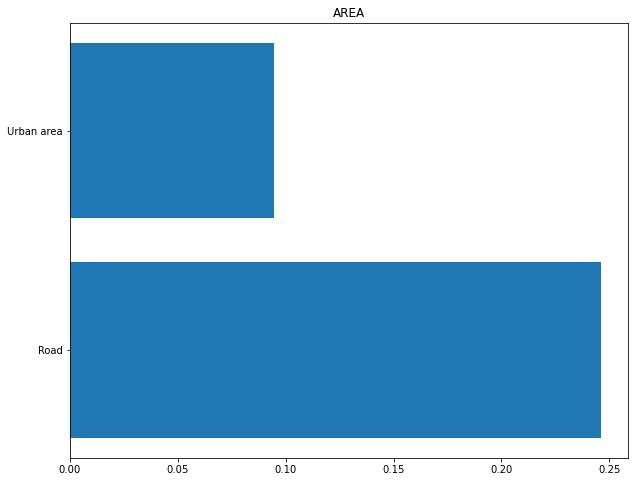

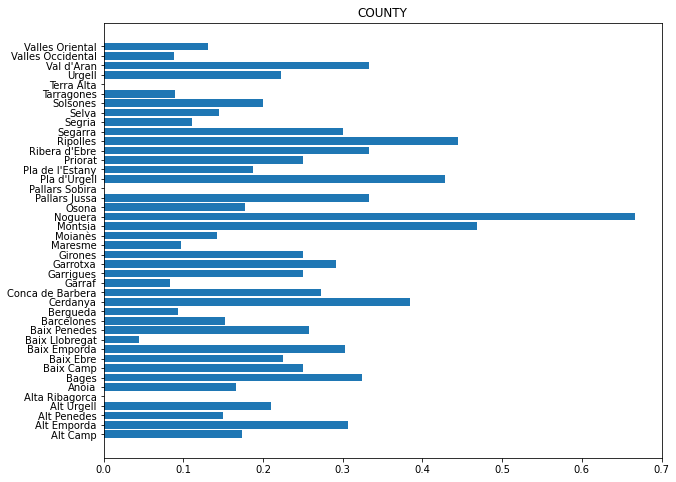

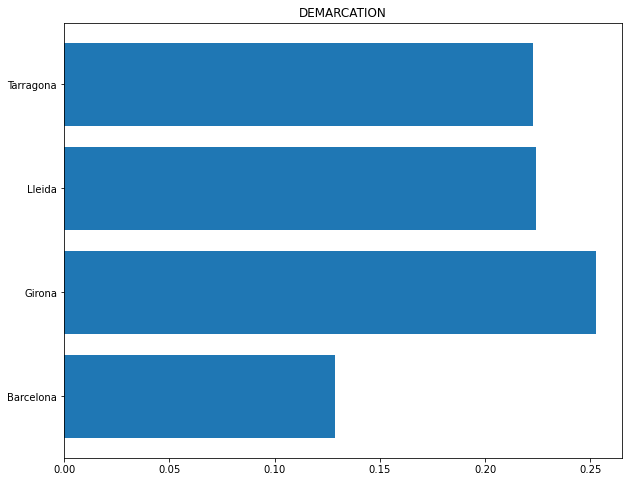

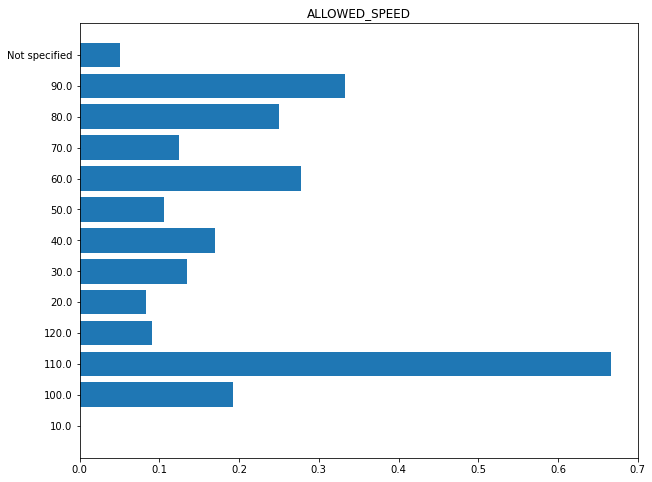

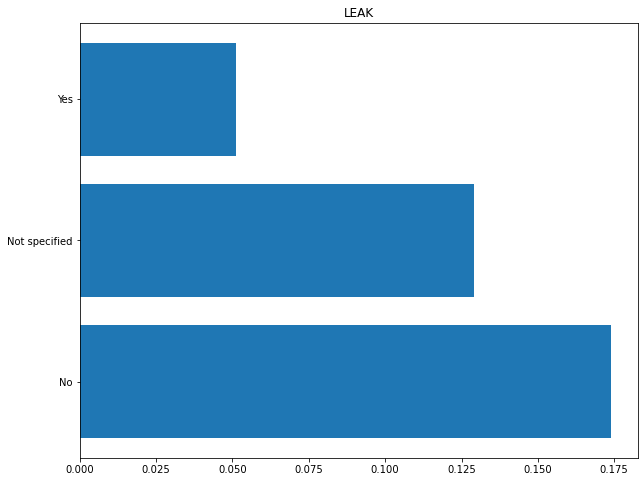

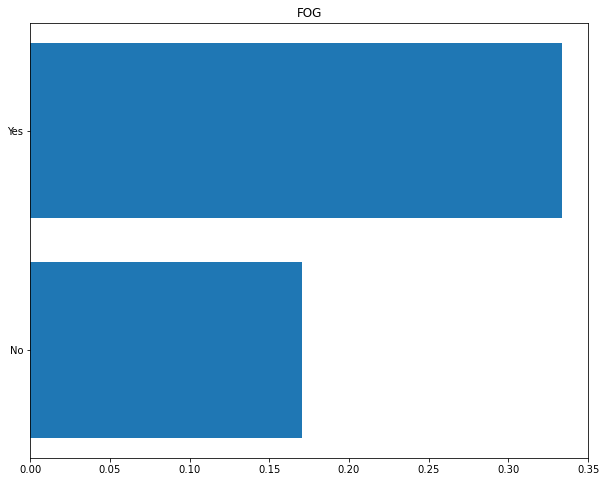

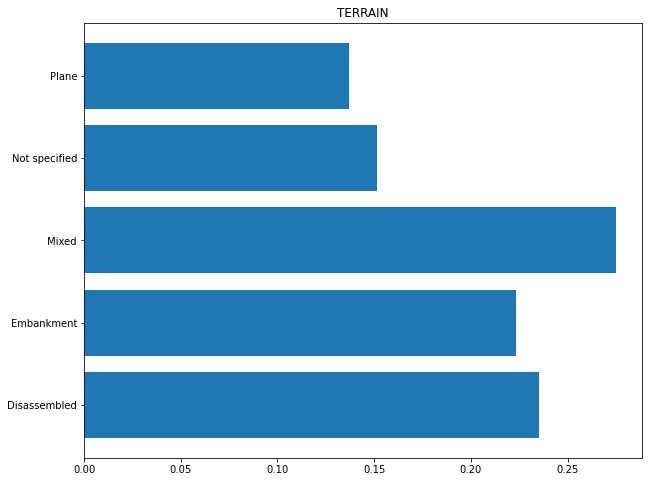

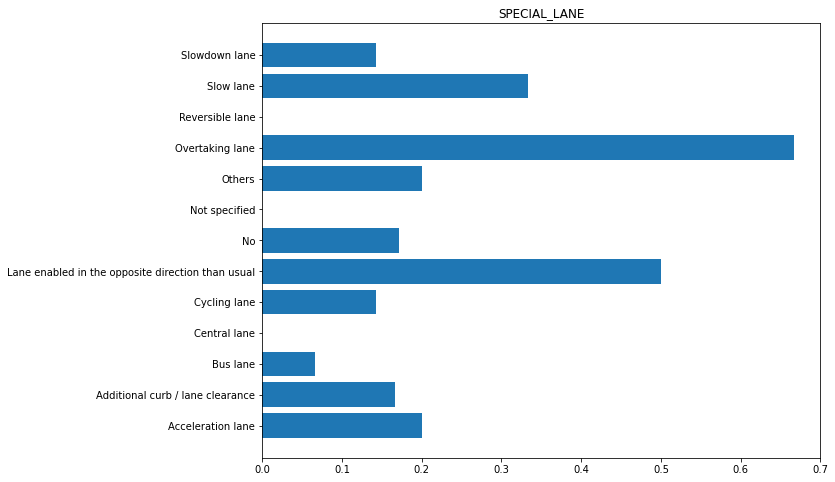

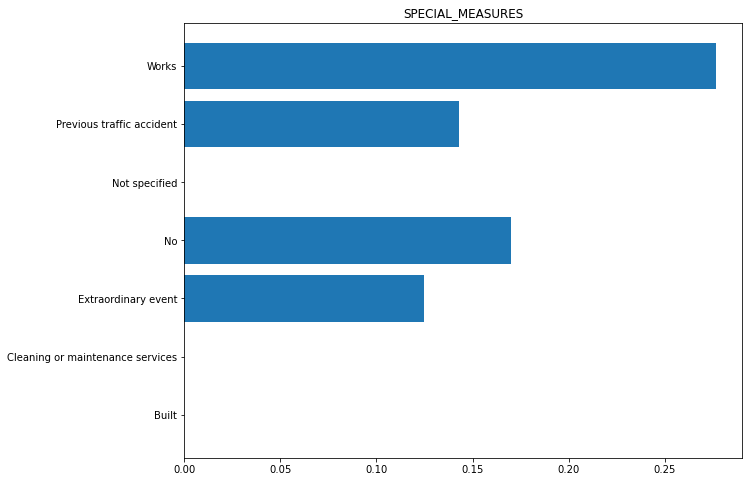

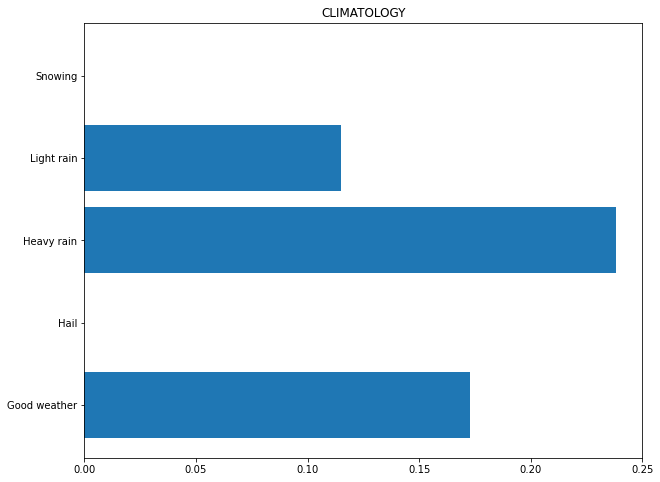

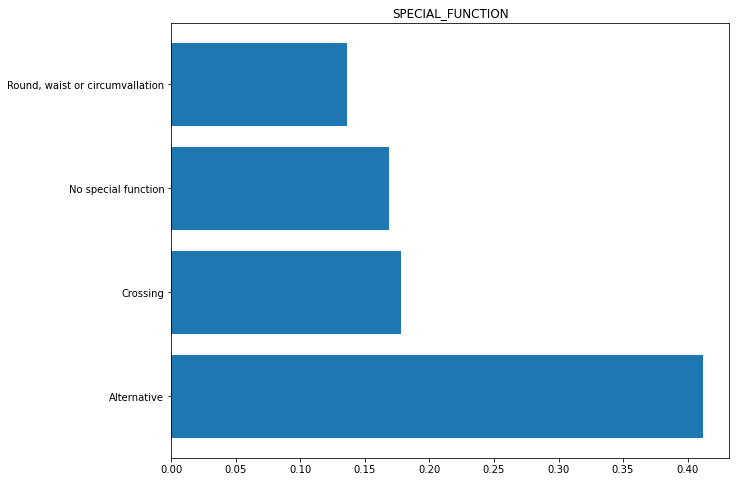

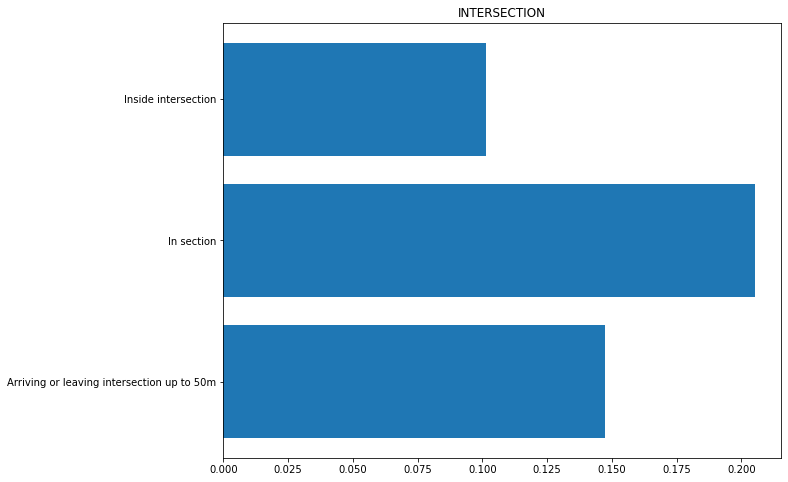

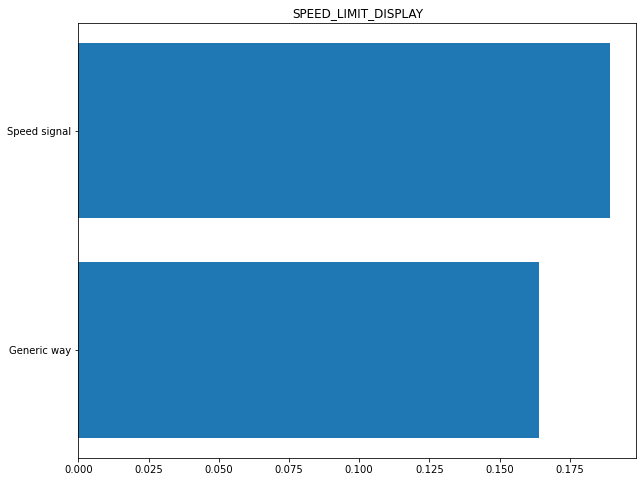

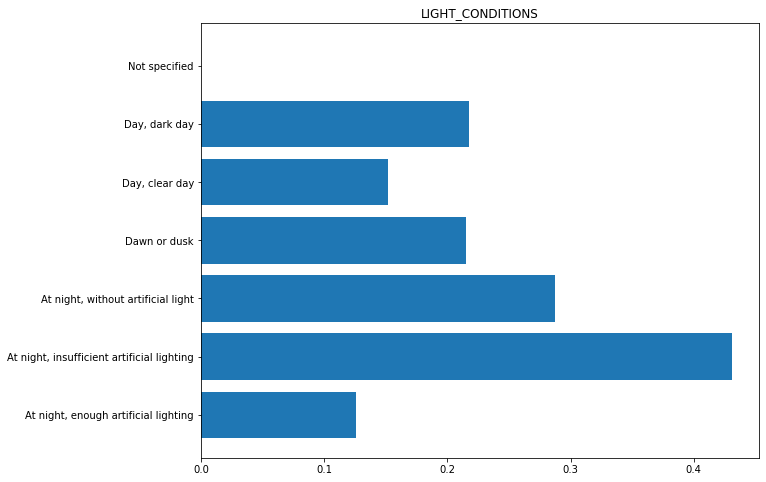

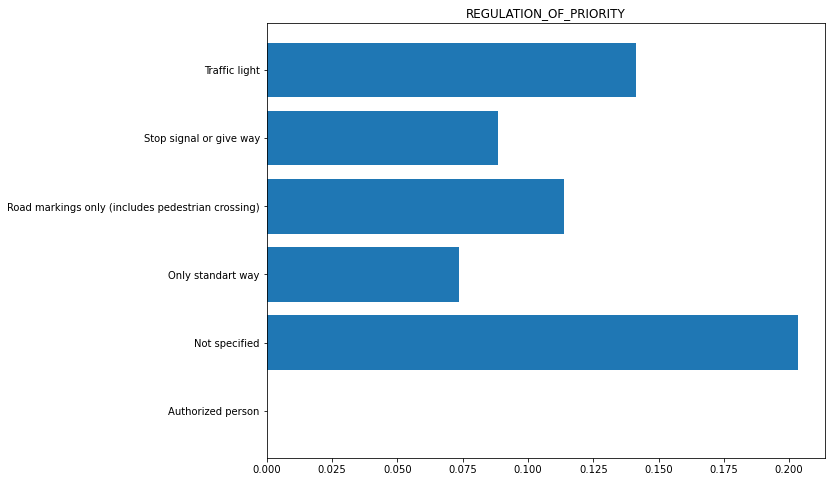

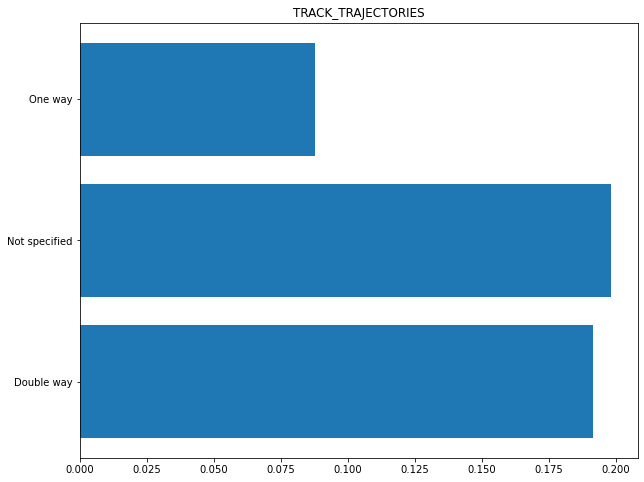

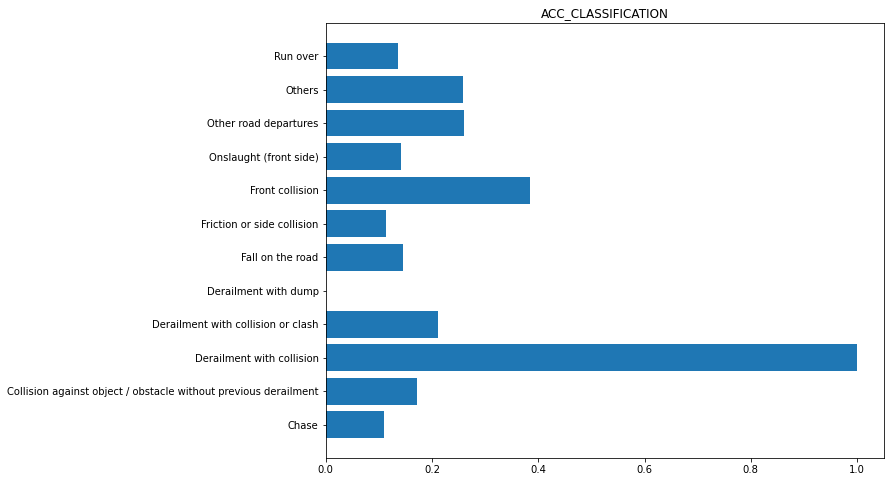

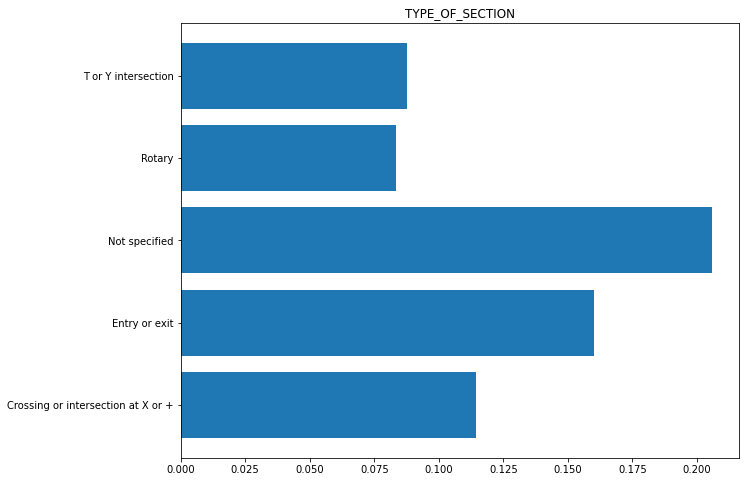

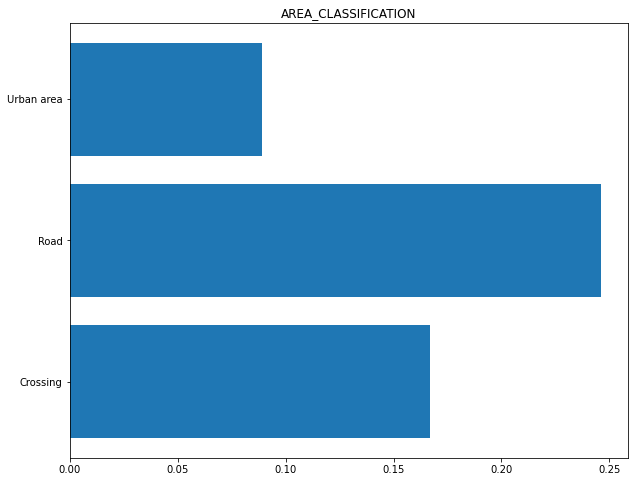

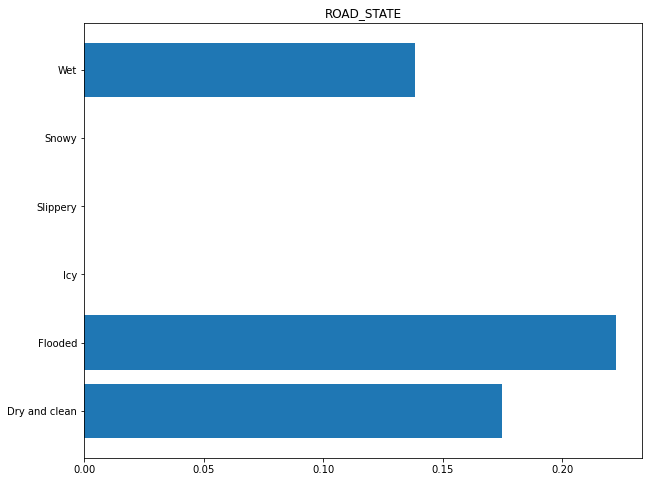

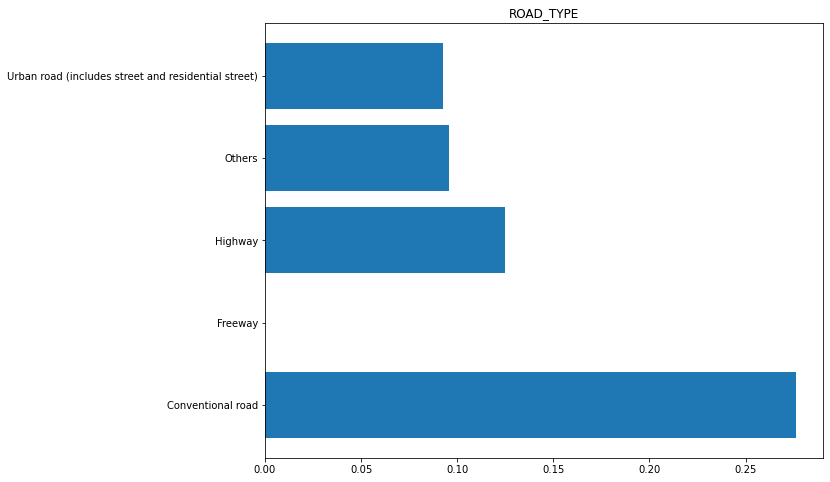

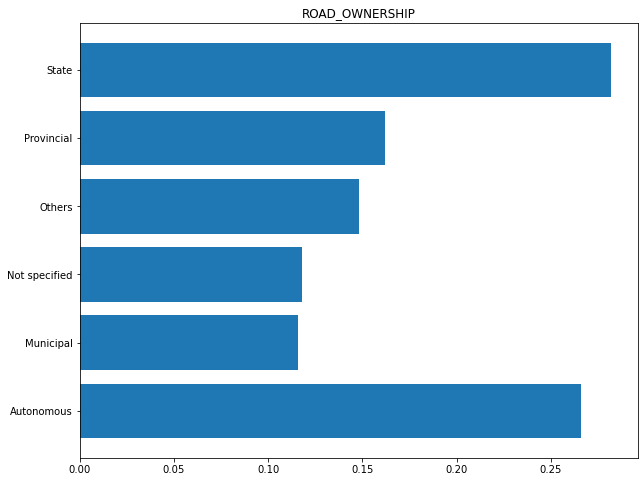

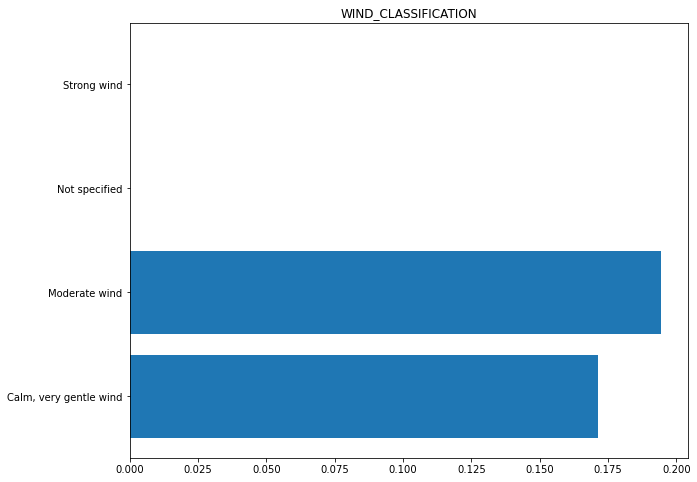

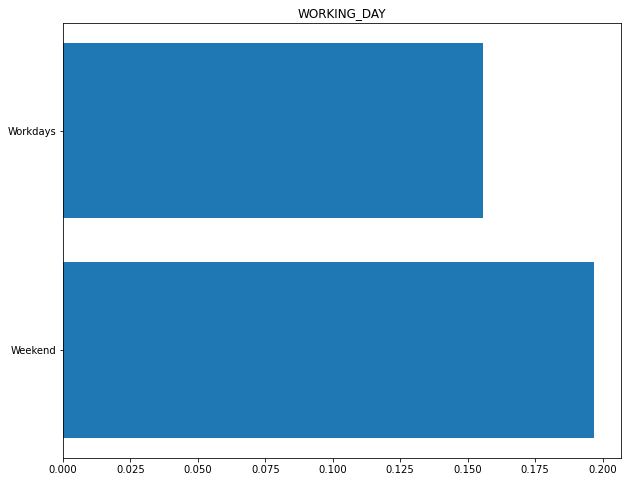

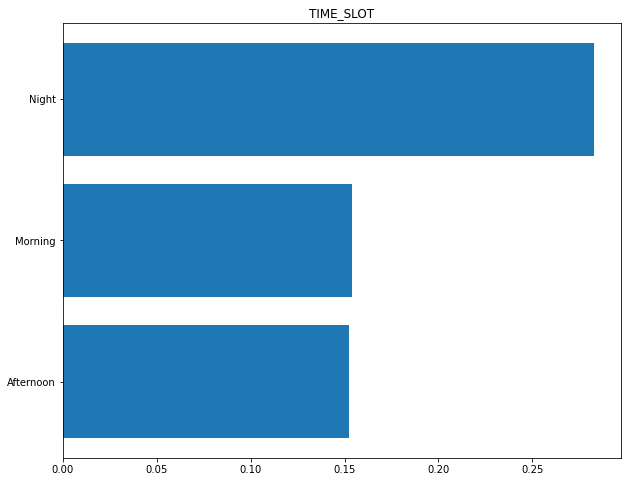

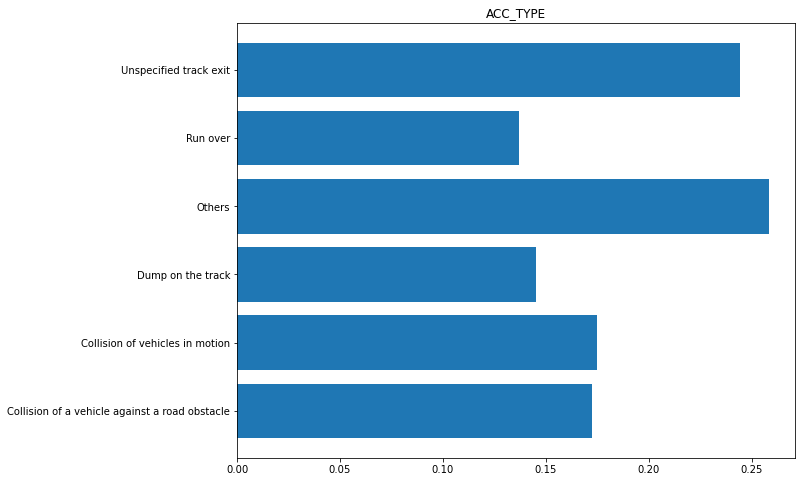

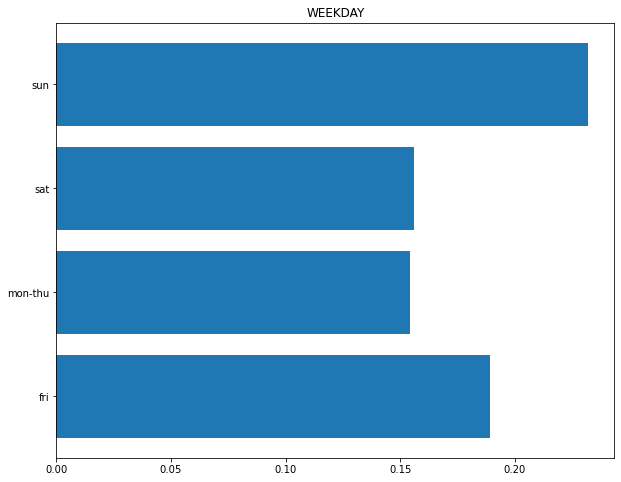

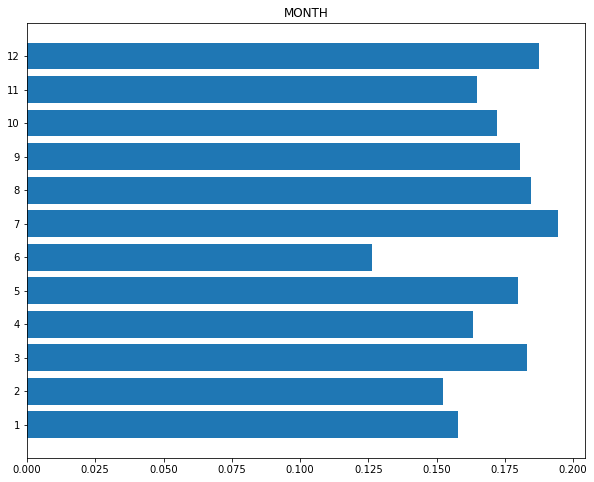

<Figure size 432x288 with 0 Axes>

In [45]:
for item in df_acc_stack.keys():
    plt.figure(figsize=((10,8)))
    plt.barh(df_acc_stack[item][df_acc_stack[item].columns[0]], df_acc_stack[item]['coef_deaths'],tick_label=df_acc_stack[item][df_acc_stack[item].columns[0]])
    plt.title(df_acc_stack[item].columns[0])
    plt.show()
plt.savefig('plt.pdf')

# Time for Machine Learning 

In [87]:
df_2010_X=df_2010.drop(['N_DEATHS', 'N_MAJ_INJURIES','N_MIN_INJURIES','count'],axis=1)
df_2010_Y=df_2010['N_DEATHS'].values

In [98]:
le = preprocessing.LabelEncoder()
for id,item in enumerate(df_2010_col):
    le.fit(df_2010_X[item])
    df_2010_X[item]=le.transform(df_2010_X[item])

In [100]:
X = preprocessing.StandardScaler().fit(df_2010_X).transform(df_2010_X.astype(float))
Y=df_2010['N_DEATHS'].values

In [102]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split( X, Y, test_size=0.2, random_state=4)
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

Train set: (1587, 29) (1587,)
Test set: (397, 29) (397,)


In [103]:
from sklearn.neighbors import KNeighborsClassifier
k = 4
neigh = KNeighborsClassifier(n_neighbors = k).fit(X_train,y_train)
yhat = neigh.predict(X_test)
from sklearn import metrics
print("Train set Accuracy: ", metrics.accuracy_score(y_train, neigh.predict(X_train)))
print("Test set Accuracy: ", metrics.accuracy_score(y_test, yhat))

Train set Accuracy:  0.8601134215500945
Test set Accuracy:  0.8564231738035264


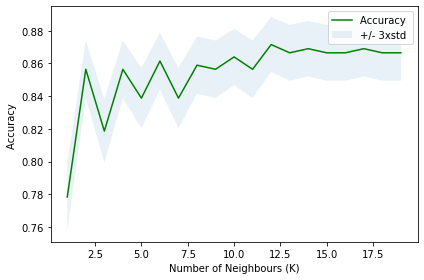

The best accuracy was with 0.871536523929471 with k= 12


In [109]:
Ks = 20
mean_acc = np.zeros((Ks-1))
std_acc = np.zeros((Ks-1))
ConfustionMx = [];
for n in range(1,Ks):
    neigh = KNeighborsClassifier(n_neighbors = n).fit(X_train,y_train)
    yhat=neigh.predict(X_test)
    mean_acc[n-1] = metrics.accuracy_score(y_test, yhat)
    std_acc[n-1]=np.std(yhat==y_test)/np.sqrt(yhat.shape[0])
plt.plot(range(1,Ks),mean_acc,'g')
plt.fill_between(range(1,Ks),mean_acc - 1 * std_acc,mean_acc + 1 * std_acc, alpha=0.10)
plt.legend(('Accuracy ', '+/- 3xstd'))
plt.ylabel('Accuracy ')
plt.xlabel('Number of Neighbours (K)')
plt.tight_layout()
plt.show()
print( "The best accuracy was with", mean_acc.max(), "with k=", mean_acc.argmax()+1) 

## Try with 2011 year

In [150]:
df_2012=1
df_2012=df_stack[2]
df_2012.drop(['YEAR','DATE', 'ROAD', 'KM','N_VICTIMS','N_VEHICLES', 'N_PEDESTRIANS',
       'N_BICYCLES', 'N_MOPEDS',
       'N_MOTORCYCLES', 'N_LIGHT_VEHICLES',
       'N_HEAVY_VEHICLES', 'N_OTHER_TYPES',
       'N_UNKNOWN_TYPE','TIME','index','SEVERITY', 'FOG_INFLUENCE', 'TERRAIN_INFLUENCE',
       'TRAFFIC_INFLUENCE', 'WEATHER_INFLUENCE', 'WIND_INFLUENCE',
       'LUMINOSITY_INFLUENCE', 'SPECIAL_MEASURES_INFLUENCE', 'OBJECT_INFLUENCE',
       'FURROWS_INFLUENCE', 'VISIBILITY_INFLUENCE',"ALTIMETRIC_LAYOUT"],axis=1,inplace=True)
df_2012['count']=1
df_acc_stack={}
df_2012_col=df_2012.columns.drop(labels=['N_DEATHS', 'N_MAJ_INJURIES','N_MIN_INJURIES','count'])
for id,item in enumerate(df_2012_col):
    if (df_2012[item].unique()).size>50:
        df_2012[item].drop
    else:
        df_acc_stack[id]=df_2012.groupby([item],as_index=False).sum()
        df_acc_stack[id]['coef_deaths']=(df_acc_stack[id]['N_DEATHS'])/(df_acc_stack[id]['count'])
        df_acc_stack[id]['coef_maj_inj']=(df_acc_stack[id]['N_MAJ_INJURIES'])/(df_acc_stack[id]['count'])
        df_acc_stack[id]['coef_min_inj']=(df_acc_stack[id]['N_MIN_INJURIES'])/(df_acc_stack[id]['count'])
df_2012_X=df_2012.drop(['N_DEATHS', 'N_MAJ_INJURIES','N_MIN_INJURIES','count'],axis=1)

KeyError: "['YEAR' 'DATE' 'ROAD' 'KM' 'N_VICTIMS' 'N_VEHICLES' 'N_PEDESTRIANS'\n 'N_BICYCLES' 'N_MOPEDS' 'N_MOTORCYCLES' 'N_LIGHT_VEHICLES'\n 'N_HEAVY_VEHICLES' 'N_OTHER_TYPES' 'N_UNKNOWN_TYPE' 'TIME' 'index'\n 'SEVERITY' 'FOG_INFLUENCE' 'TERRAIN_INFLUENCE' 'TRAFFIC_INFLUENCE'\n 'WEATHER_INFLUENCE' 'WIND_INFLUENCE' 'LUMINOSITY_INFLUENCE'\n 'SPECIAL_MEASURES_INFLUENCE' 'OBJECT_INFLUENCE' 'FURROWS_INFLUENCE'\n 'VISIBILITY_INFLUENCE' 'ALTIMETRIC_LAYOUT'] not found in axis"

In [138]:
for id,item in enumerate(df_2012_col):
    le.fit(df_2012_X[item])
    df_2012_X[item]=le.transform(df_2012_X[item])
X_2012 = preprocessing.StandardScaler().fit(df_2012_X).transform(df_2012_X.astype(float))
Y_2012 =df_2012['N_DEATHS'].values

In [139]:
k = 12
neigh12 = KNeighborsClassifier(n_neighbors = k).fit(X_train,y_train)
yhat12 = neigh.predict(X_2012)
metrics.accuracy_score(Y_2012, yhat12)

0.8670487106017192

In [ ]:
knn_yhat = knn7.predict(test_df_X)
print("KNN Jaccard index: %.2f" % jaccard_similarity_score(test_df_Y, knn_yhat))
print("KNN F1-score: %.2f" % f1_score(test_df_Y, knn_yhat, average='weighted') )

In [149]:
df_2012

,AREA,CITY,COUNTY,DEMARCATION,N_DEATHS,N_MAJ_INJURIES,N_MIN_INJURIES,ALLOWED_SPEED,LEAK,FOG,...,ROAD_STATE,ROAD_TYPE,ROAD_OWNERSHIP,WIND_CLASSIFICATION,WORKING_DAY,TIME_SLOT,ACC_TYPE,WEEKDAY,MONTH,count
0,Urban area,BARCELONA,Barcelones,Barcelona,0.0,1.0,0.0,100.0,No,No,...,Dry and clean,Urban road (includes street and residential st...,Not specified,"Calm, very gentle wind",Workdays,Morning,Collision of vehicles in motion,fri,5,1
1,Urban area,VIC,Osona,Barcelona,1.0,0.0,0.0,100.0,No,No,...,Dry and clean,Urban road (includes street and residential st...,Not specified,"Calm, very gentle wind",Workdays,Morning,Run over,mon-thu,6,1
2,Road,"BORGES BLANQUES, LES",Garrigues,Lleida,0.0,1.0,0.0,100.0,No,No,...,Dry and clean,Conventional road,State,"Calm, very gentle wind",Weekend,Morning,Collision of vehicles in motion,sat,7,1
3,Road,CABANELLES,Alt Emporda,Girona,1.0,1.0,0.0,100.0,No,No,...,Dry and clean,Conventional road,State,"Calm, very gentle wind",Weekend,Morning,Unspecified track exit,sat,3,1
4,Road,CALLUS,Bages,Barcelona,0.0,2.0,0.0,60.0,No,No,...,Dry and clean,Conventional road,Autonomous,"Calm, very gentle wind",Weekend,Night,Collision of vehicles in motion,sun,6,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1945,Urban area,MATARO,Maresme,Barcelona,0.0,1.0,0.0,Not specified,No,No,...,Slippery,Urban road (includes street and residential st...,Not specified,"Calm, very gentle wind",Weekend,Morning,Dump on the track,sat,5,1
1946,Urban area,BADALONA,Barcelones,Barcelona,0.0,1.0,0.0,Not specified,No,No,...,Dry and clean,Urban road (includes street and residential st...,Not specified,"Calm, very gentle wind",Workdays,Afternoon,Dump on the track,mon-thu,3,1
1947,Road,ALMACELLES,Segria,Lleida,0.0,1.0,0.0,40.0,No,No,...,Dry and clean,Others,Municipal,"Calm, very gentle wind",Weekend,Afternoon,Unspecified track exit,fri,10,1
1948,Urban area,SANTA COLOMA DE GRAMANET,Barcelones,Barcelona,0.0,1.0,0.0,Not specified,No,No,...,Dry and clean,Urban road (includes street and residential st...,Not specified,"Calm, very gentle wind",Workdays,Afternoon,Run over,mon-thu,7,1
